# Dereverb - DAAP Project

Students: 

*   Federico Maver ( ID: 10565151, MATR: 952840 )
*   Filippo Gualtieri ( ID: , MATR: 953546 )

Import libraries:

In [236]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa, librosa.display
import pyroomacoustics as pra
import acoustics as ac
import scipy.signal as signal
# from scipy.io import wavfile
import IPython.display as ipd
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import soundfile as sf
import control

#from pyAudioAnalysis import audioSegmentation as aS

Utilities/Functions:

In [237]:
# from samples axis to time axis (in seconds)

def time_axis(signal, fs):
    t = np.arange(len(signal))/fs
    return t

def complex_cepstrum(x, n):
    spectrum = np.fft.fft(x, n=n)
    unwrapped_phase = np.unwrap(np.angle(spectrum))
    log_spectrum = np.log(np.abs(spectrum)) + 1j * unwrapped_phase
    ceps = np.fft.ifft(log_spectrum).real
    return ceps

def inverse_complex_cepstrum(ceps):
    CEPS=np.fft.fft(ceps)
    X=np.exp(CEPS)
    x=np.fft.ifft(X)
    return x

# def complex_cepstrum_kennedy(x, n):
#     spectrum = np.fft.fft(x, n=n)
#     #unwrapped_phase = np.unwrap(np.angle(spectrum))
#     log_spectrum = np.log(np.abs(spectrum)) #+ 1j * unwrapped_phase
#     ceps = np.fft.ifft(log_spectrum).real
#     return ceps

## Part 1: RIR and reverberation
From the image we can see that values of beta should be chosen between 0.2 for small rooms (4 m per side) and 1.8 for very big rooms (30 m per side);

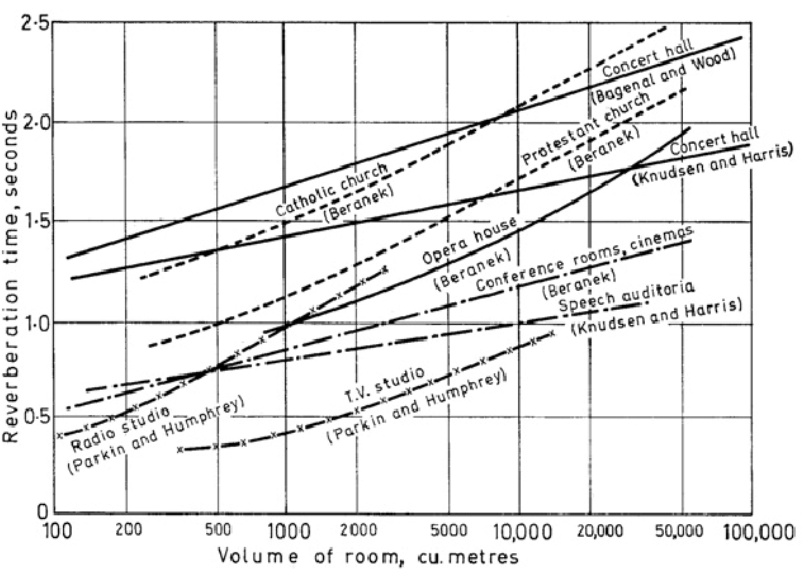

In [238]:
ipd.Image(filename = "images/RevTime1.png", width = 600, height = 300)

Let's define some parameters:

In [239]:
# speed of sound (m/s)
v_sound = 340
# -> meters = samples*c/fs
# room (110, 130, 70)samples 
# source (20, 30, 10)samples
# receiver (50, 60, 40)samples


In [240]:
fs = 10000 # sampling rate (Hz)

rt60_tgt = 0.9  # reverberation time (s)

room_dim = [3.74, 4.42, 2.38]  # room dimensions (m)

source_pos = [0.68, 1.02, 0.34] # x, y, z position of the source (m)
mic_locs = np.c_[ [1.7, 2.04, 1.36] ] # location of the microphone / microphone array (m)

Visualization of the room with source and mics:

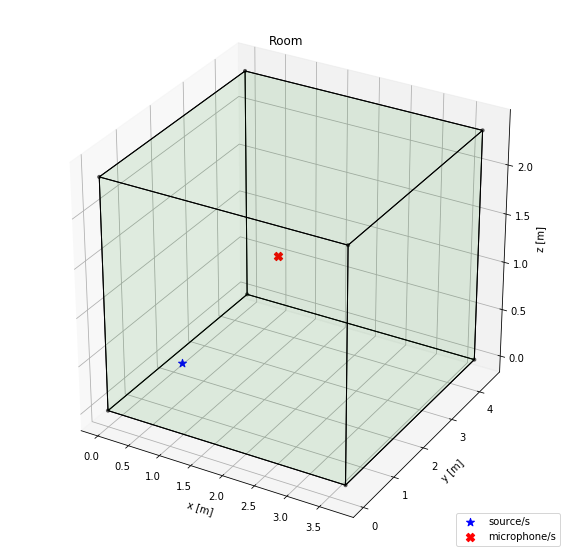

In [241]:
# vertices of the room
v = np.array([[0, 0, 0], [room_dim[0], 0, 0], [room_dim[0], room_dim[1], 0], [0, room_dim[1], 0], [0, 0, room_dim[2]], [room_dim[0], 0, room_dim[2]], [room_dim[0], room_dim[1], room_dim[2]], [0, room_dim[1], room_dim[2]]])

# room, sources and mics plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(source_pos[0], source_pos[1], source_pos[2], c='b', s=70, marker='*')
ax.scatter(mic_locs[0, :], mic_locs[1, :], mic_locs[2, :], c='r', s=70, marker='X')

ax.scatter3D(v[:, 0], v[:, 1], v[:, 2], s=10, c='k', alpha=0.5)

# generate list of sides' polygons of our room
walls = [ [v[0],v[1],v[2],v[3]], [v[4],v[5],v[6],v[7]], [v[2],v[3],v[7],v[6]], [v[0],v[3],v[7],v[4]], [v[0],v[1],v[5],v[4]], [v[1],v[2],v[6],v[5]] ]

# plot sides
ax.add_collection3d(Poly3DCollection(walls, facecolors='green', linewidths=1, edgecolors='k', alpha=0.05))

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('Room')
ax.legend(('source/s','microphone/s'), loc='lower right', frameon=True);

Now generate the RIR and apply it to the audio files

In [242]:
# import a mono wavfile as the source signal: the sampling frequency should match that of the room
#  OSR_us_000_0010_8k.wav AudioSamples/Voice_ChangeHasComeToAmerica.wav

audio, fs = librosa.load('audio/OSR_us_000_0010_8k.wav', sr=fs)
audio=audio[:5*fs]

In [243]:
# We invert Sabine's formula to obtain the parameters for the ISM simulator
e_absorption, max_order = pra.inverse_sabine(rt60_tgt, room_dim)

print("Reflectivity of the walls: {}%".format((1-e_absorption)*100))

# Create the room
room = pra.ShoeBox(room_dim, fs=fs, materials=pra.Material(e_absorption), max_order=max_order);

# volume of the room
print("The volume of the room is {} m\u00b3".format(room.get_volume()))

Reflectivity of the walls: 90.20480895759823%
The volume of the room is 39.34330368041992 m³


In [244]:
# place the source in the room
room.add_source(source_pos, signal=audio); #delay=0.5

# place the microphone array in the room
room.add_microphone_array(mic_locs);

In [245]:
# Run the simulation (this will also build the RIR automatically)
room.simulate()

# Save the reverberated audio into a file
# room.mic_array.to_wav(
#     f"audio/generated/voiced_aREV.wav",
#     norm=True,
#     bitdepth=np.int16,
# )

x_rev = room.mic_array.signals[0, :];

global_delay = pra.constants.get("frac_delay_length") // 2

print('Global delay introduced by the simulation:', global_delay)

# measure the reverberation time
rt60 = room.measure_rt60()
print("The desired RT60 was {} s".format(rt60_tgt))
print("The measured RT60 is {} s".format(rt60[0, 0]))

Global delay introduced by the simulation: 40
The desired RT60 was 0.9 s
The measured RT60 is 1.1664999999999999 s


*Do we need to take into account the global delay when computing filters?*

### Data arrays preparation:

In [246]:
signal_rev = room.mic_array.signals[0,:]
h_meas = np.squeeze(np.array(room.rir))
N_fft = int(pow(2, np.ceil(np.log(len(signal_rev))/np.log(2))))

print('Original signal:', audio.shape)
print('RIR:', h_meas.shape )
print('Reverberated signal:', signal_rev.shape)
print('The closest power of 2 to the reverberated signal:', N_fft)

#N_fft = 16384 # try different values
freqs=np.arange(0,N_fft)*(fs/N_fft) # frequency axis

Original signal: (50000,)
RIR: (19837,)
Reverberated signal: (69836,)
The closest power of 2 to the reverberated signal: 131072


The power of two is calculated so that the final length of the signal is at least N_samples(original signal) + N_samples(RIR)-1 so that we can safely implement the circular convolution by exploiting the fft

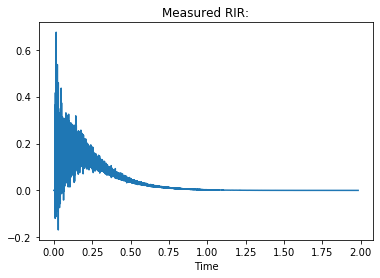

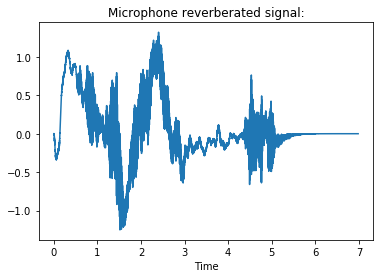

In [247]:
# Plot the RIR
plt.figure()

plt.plot(time_axis(h_meas, fs), h_meas)
plt.title("Measured RIR:")
plt.xlabel("Time");

# plot signal at microphone

plt.figure()
plt.plot(time_axis(signal_rev, fs), signal_rev)
plt.title("Microphone reverberated signal:")
plt.xlabel("Time");

In [248]:
# save RIR into a wav
# sf.write('audio/RIR.wav', h_meas, samplerate=fs)

#### Audio files
Dry signal:

In [249]:
ipd.display(ipd.Audio(audio, rate=fs))

Reverberated signal:

In [250]:
ipd.display(ipd.Audio(signal_rev, rate=fs))

### Generated RIR: minimum phase or not?

In [251]:
# pure delay: distance btw source and receiver
distance_m = np.sqrt(np.sum((np.array((source_pos))-(mic_locs[0]))**2))

distance_s = int((distance_m/v_sound)*fs)
distance_s = distance_s + global_delay # maybe we need to take into account the global delay?

print("Delay between source and microphone (in samples):", distance_s)

Delay between source and microphone (in samples): 93


<ipython-input-252-12fc1def3420>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig1.add_subplot(111)


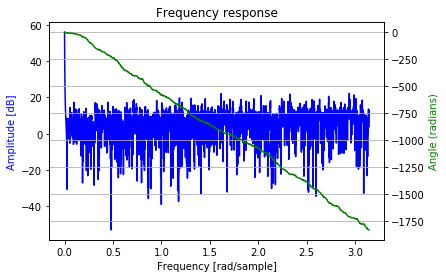

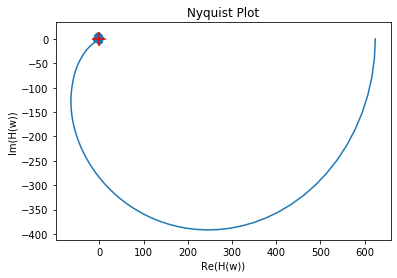

In [252]:
# shift h to remove the delay

h_orig_shift = h_meas[distance_s:]
#h_orig_shift = [0.5, 0.4]

f, T = signal.freqz(h_orig_shift, worN=N_fft)

fig1 = plt.figure()
plt.title('Frequency response')
ax1 = fig1.add_subplot(111)
plt.plot(f, 20 * np.log10(abs(T)), 'b')
plt.ylabel('Amplitude [dB]', color='b')
plt.xlabel('Frequency [rad/sample]')
ax2 = ax1.twinx()
angles = np.unwrap(np.angle(T))
plt.plot(f, angles, 'g')
plt.ylabel('Angle (radians)', color='g')
plt.grid()
plt.axis('tight')

fig2 = plt.figure()
plt.title('Nyquist Plot')
#plt.plot(np.real(T), np.imag(T), zorder=-1)
plt.plot(np.real(T), np.imag(T), zorder=-1) #shifted in 0... ok?! I THINK NO -np.real(T[0]) -np.imag(T[0])
plt.scatter(0,0, c='r', s=180, marker='+') #-1/np.real(T[0])
plt.ylabel('Im(H(w))')
plt.xlabel('Re(H(w))')
plt.show()

#sys = control.tf(h_orig_shift, 1)
#print(h_orig_shift)
#control.pzmap(sys, plot=True, title='Pole Zero Map');



<ipython-input-253-a7061df80a18>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig1.add_subplot(111)


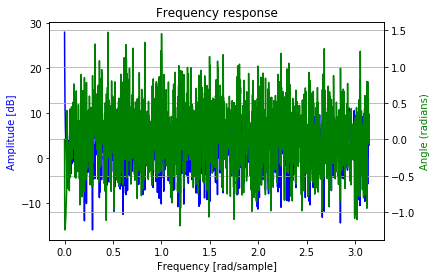

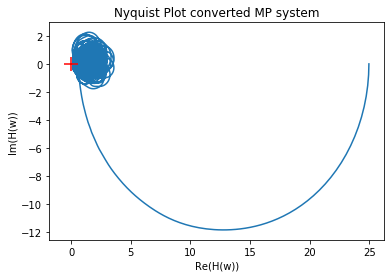

In [253]:
mp_sys=signal.minimum_phase(h_meas)
f2, Q = signal.freqz(mp_sys, worN=N_fft)

fig1 = plt.figure()
plt.title('Frequency response')
ax1 = fig1.add_subplot(111)
plt.plot(f, 20 * np.log10(abs(Q)), 'b')
plt.ylabel('Amplitude [dB]', color='b')
plt.xlabel('Frequency [rad/sample]')
ax2 = ax1.twinx()
angles2 = np.unwrap(np.angle(Q))
plt.plot(f2, angles2, 'g')
plt.ylabel('Angle (radians)', color='g')
plt.grid()
plt.axis('tight')


fig2 = plt.figure()
plt.title('Nyquist Plot converted MP system')
plt.plot(np.real(Q), np.imag(Q), zorder=-1) #shifted in 0... ok?! -np.real(T[0]) -np.imag(T[0])
plt.scatter(0,0, c='r', s=180, marker='+') #-1/np.real(T[0])
plt.ylabel('Im(H(w))')
plt.xlabel('Re(H(w))')
plt.show()

#sys = control.tf(mp_sys, 1)
#print(h_orig_shift)
#control.pzmap(sys, plot=True, title='Pole Zero Map');

## Part 2: Estimation of h (Ziegler)

### Standard Windowing:
*  Window the signal in a series of frames
*  Compute complex cepstrum of each frame
*  Estimate $\hat{h}_{est}$ as:
$$\hat{h}_{est}(q,\tau)=\frac{1}{L}\cdot\sum\limits_{l=\tau}^{\tau+L-1}\hat{x}(q,l)$$

In [254]:
# window the signal:
frame_length = 2048
signal_length = len(signal_rev)
N_frames = int(np.ceil(signal_length/frame_length))

# zero-pad the signal such that it is exactly N_frames*frame_length long
signal_length_ = int(N_frames*frame_length)

signal_rev_ = np.pad(signal_rev, (0, signal_length_-signal_length))

# extract frames in a matrix
framed_signal = []
for i in range(N_frames):
    framed_signal.append(signal_rev_[i*frame_length:(i+1)*frame_length])

framed_signal = np.array(framed_signal)
print("(N_frames, frame_length) =", framed_signal.shape)

(N_frames, frame_length) = (35, 2048)


In [255]:
# take the mean value of  complex cepstra of a certain number of frames

# h in the article is time varying (tau), while our h is fixed!

start = 0
stop = N_frames
L = stop-start

print("We are considering a number of frames which is:", L)

framed_signal_cepstra = complex_cepstrum(framed_signal, frame_length)

h_cepstra_est = np.mean(framed_signal_cepstra[start:stop,:], axis=0)
h_est = inverse_complex_cepstrum(h_cepstra_est)

We are considering a number of frames which is: 35


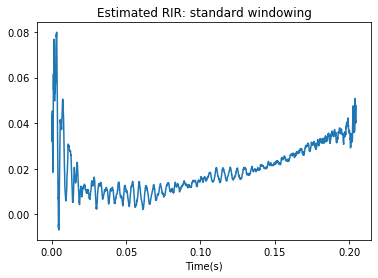

In [256]:
plt.figure()
time = time_axis(h_est, fs)
plt.title("Estimated RIR: standard windowing")
plt.xlabel("Time(s)")
plt.plot(time, h_est);

### Speech Segmentation:
In order to avoid cross-talking between frames, segment the signal and use only speech parts and then compute $h_{est}$:
*  Segment the signal retaining voice parts
*  Compute complex cepstrum of each segment
*  Estimate $\hat{h}_{est}$ as:
$$\hat{h}_{est}(q,\tau)=\frac{1}{L}\cdot\sum\limits_{l=\tau}^{\tau+L-1}\hat{x}(q,l)$$

Audio segmentation using pyAudioAnalyisis:

## Part 3: Inverse filtering (Kennedy)

In [257]:
h = h_est
h = h_meas

**NOTATION:**
*  n = time sample
*  N = number of time samples
*  k = frequency bin
*  K = number of frequency bins

### Minimum-Phase/Allpass Decomposition: Standard Approach

1. Compute the discrete Fourier transform of \\(h(n)\\), or \\[H(k) = DFT[h(n)] = \sum_{n=0}^{N-1} h(n)e^{-j(2\pi/N)kn}\\]

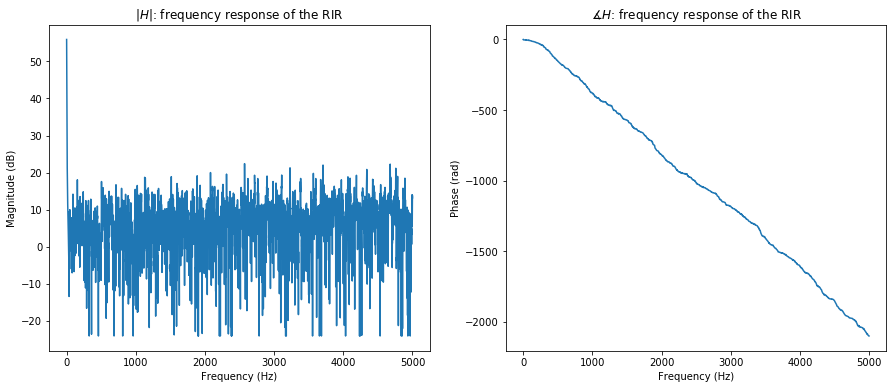

In [293]:
H = np.fft.fft(h, N_fft)
H_phase = np.unwrap(np.angle(H))

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title("$|H|$: frequency response of the RIR")
plt.plot(freqs[0:N_fft//2], librosa.amplitude_to_db(np.abs(H[0:N_fft//2])))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')


plt.subplot(1,2,2)
plt.title("$\measuredangle H$: frequency response of the RIR")
plt.plot(freqs[0:N_fft//2], H_phase[0:N_fft//2])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (rad)')


plt.show()

2. Compute the logarithm of the frequency response, as \\(\hat{H}(k) = \log|H(k)| + j\arg(H(k))\\)  in particular we are interested in \\(C(k)=log|H(k)|\\)

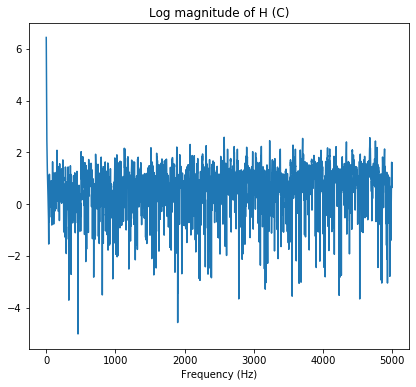

In [295]:
C = np.log(np.abs(H))

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title("Log magnitude of H (C)")
plt.plot(freqs[0:N_fft//2],C[0:N_fft//2])
plt.xlabel('Frequency (Hz)')

plt.show()

3. Compute the even part of the complex cepstrum as: \\[c(n)=\hat{h}_e(n) = DFT^{-1}[C(k)] = \frac{1}{N}\sum_{k=0}^{N-1} C(k)e^{j(2\pi/N)kn} \\]

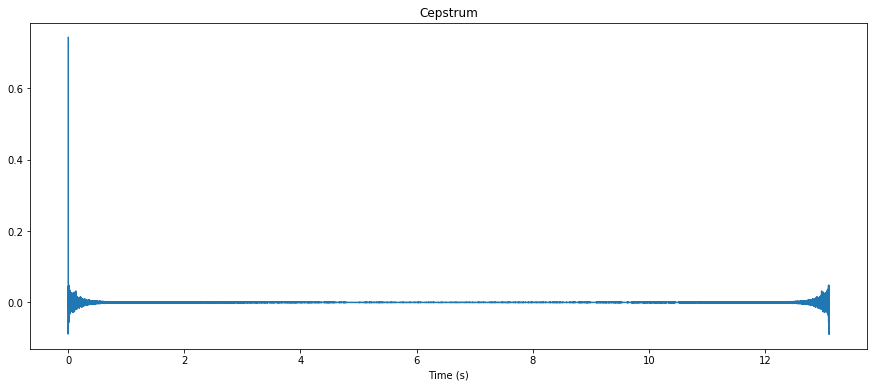

In [285]:
c=np.real(np.fft.ifft(C))
time=time_axis(c,fs)
plt.figure(figsize=(15,6))
plt.title("Cepstrum")
plt.plot(time,c)
plt.xlabel('Time (s)')

plt.show()

4. Calculate the corresponding complex cepstrum of the minimum phase sequence: \\[\hat{m}(n)=\hat{h}_{mp}(n) = \begin{cases} c(n), & n=0,N/2 \\ 2c(n), & 1\leq n < N/2\\ 0, & N/2 < n \leq N-1 \end{cases} \\]
this passage is used to put the negative quefrencies to zero in order to calculate the minimum phase components

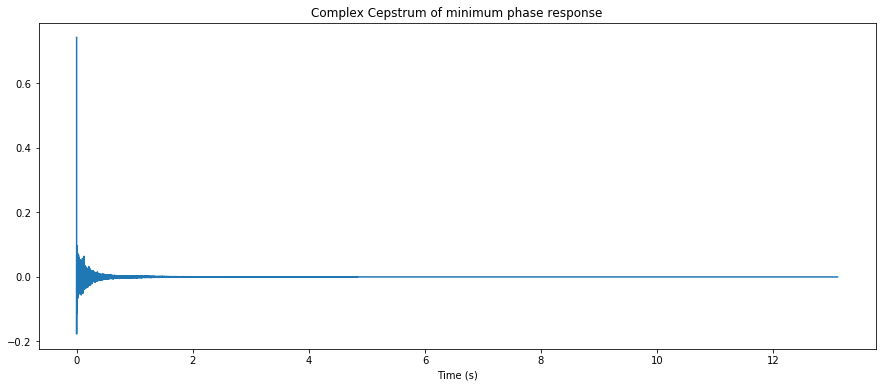

In [286]:
N=len(c)
m_hat=np.zeros(N)
m_hat[0]=c[0]
m_hat[N//2]=c[N//2]
m_hat[1:(N//2)-1]=2*c[1:(N//2)-1]


time=time_axis(m_hat,fs)
plt.figure(figsize=(15,6))
plt.title("Complex Cepstrum of minimum phase response")
plt.plot(time,m_hat)
plt.xlabel('Time (s)')

plt.show()

5. Compute the DFT of \\(\hat{h}_{mp}(n)\\), or \\( \hat{m}(n)\\) as: \\[ \hat{M}(k) = \hat{H}_{mp}(k) = DFT[\hat{m}(n)] = \sum_{n=0}^{N-1} \hat{m}(n)e^{-j(2\pi/N)kn}\\]

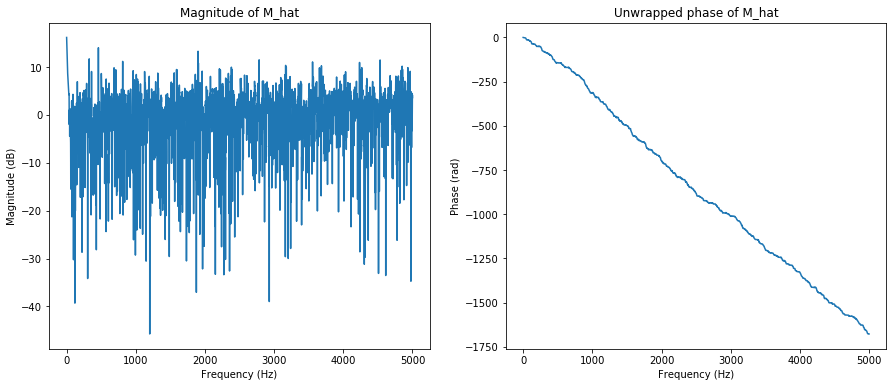

In [291]:
M_hat=np.fft.fft(m_hat)
M_hat_phase = np.unwrap(np.angle(M_hat))

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title("Magnitude of M_hat")
plt.plot(freqs[0:N_fft//2], librosa.amplitude_to_db(np.abs(M_hat[0:N_fft//2])))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')

plt.subplot(1,2,2)
plt.title("Unwrapped phase of M_hat")
plt.plot(freqs[0:N_fft//2], M_hat_phase[0:N_fft//2])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (rad)')

plt.show()

6. Infer the minimum phase part of \\(H(k)\\), as \\(M(k) = exp[\hat{M}(k)]\\)

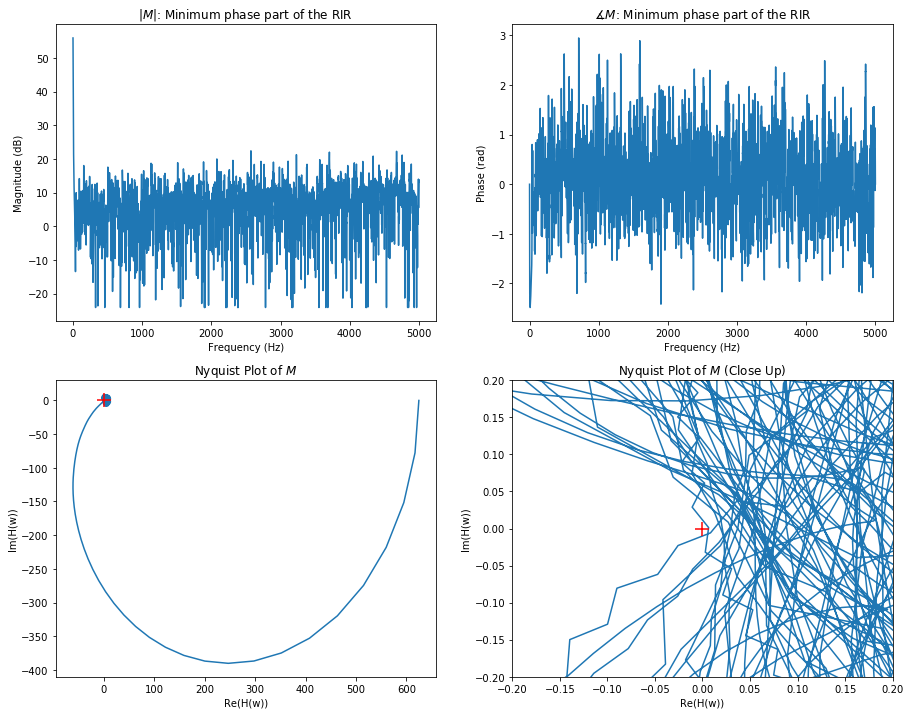

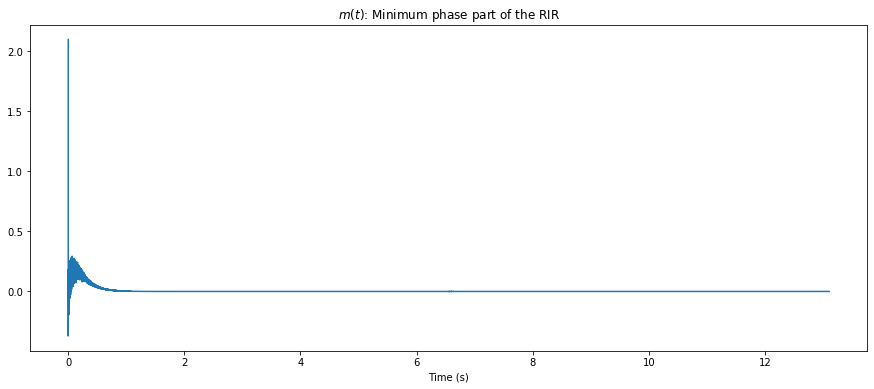

In [292]:
M = np.exp(M_hat)
M_phase = np.unwrap(np.angle(M))
m = np.real(np.fft.ifft(M))

plt.figure(figsize=(15,12))
plt.subplot(2,2,1)
plt.title("$|M|$: Minimum phase part of the RIR")
plt.plot(freqs[0:N_fft//2], librosa.amplitude_to_db(np.abs(M[0:N_fft//2])))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')

plt.subplot(2,2,2)
plt.title("$\measuredangle M$: Minimum phase part of the RIR")
plt.plot(freqs[0:N_fft//2], M_phase[0:N_fft//2])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (rad)')

plt.subplot(2,2,3)
plt.title('Nyquist Plot of $M$')
plt.plot(np.real(M[0:N_fft//2]), np.imag(M[0:N_fft//2]), zorder=-1) #shifted in 0... ok?! -np.real(T[0]) -np.imag(T[0])
plt.scatter(0,0, c='r', s=180, marker='+') #-1/np.real(T[0])
plt.ylabel('Im(H(w))')
plt.xlabel('Re(H(w))')


plt.subplot(2,2,4)
plt.title('Nyquist Plot of $M$ (Close Up)')
plt.plot(np.real(M[0:N_fft//2]), np.imag(M[0:N_fft//2]), zorder=-1) #shifted in 0... ok?! -np.real(T[0]) -np.imag(T[0])
plt.scatter(0,0, c='r', s=180, marker='+') #-1/np.real(T[0])
plt.ylabel('Im(H(w))')
plt.xlabel('Re(H(w))')
plt.xlim([-0.2,0.2])
plt.ylim([-0.2,0.2]);

plt.figure(figsize=(15,6))
plt.title('$m(t)$: Minimum phase part of the RIR')
time=time_axis(m,fs)
plt.plot(time,m)
plt.xlabel('Time (s)');

Now that \\( M(k) = H_{mp}(k)\\) is known, the remaining allpass component can be computed as \\(A(k) =H_{ap}(k)= H(k)G_{mp}(k)\\), where \\(G_{mp}(k)=1/H_{mp}(k)=1/M(k)\\) is the minimum phase inverse.

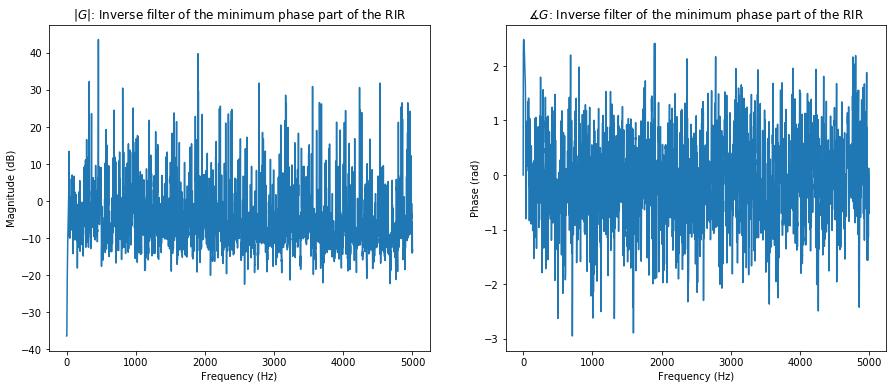

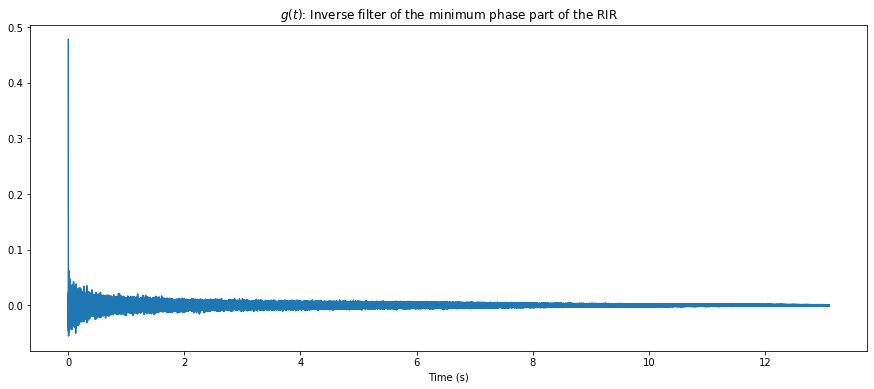

In [296]:
G=1/M
G_phase = np.unwrap(np.angle(G))
g = np.real(np.fft.ifft(G))

# # ALL PASS CAN'T BE INVERTED! WHY DOES IT WORK?!
# A_INV=(1/A) # *np.exp(-1j*2*np.pi*freqs*2)#6.5536

# A_INV_UNW=np.unwrap(np.angle(A_INV))

plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.title("$|G|$: Inverse filter of the minimum phase part of the RIR")
plt.plot(freqs[0:N_fft//2], librosa.amplitude_to_db(np.abs(G[0:N_fft//2])))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')

plt.subplot(1,2,2)
plt.title("$\measuredangle G$: Inverse filter of the minimum phase part of the RIR")
plt.plot(freqs[0:N_fft//2],G_phase[0:N_fft//2])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (rad)')

#a_inv=np.real(np.fft.ifft(A_INV))

time=time_axis(g,fs)
plt.figure(figsize=(15,6))
plt.title("$g(t)$: Inverse filter of the minimum phase part of the RIR")
plt.plot(time, g)
plt.xlabel('Time (s)')

plt.show()

Sometimes (depending on the RT60 parameter) we can get a truncated inverse minimum phase.  
That happens because the inverse of the zeros in the minimum phase filter may lie close to the unit circle thus causing a minimum phase inverse of very long duration.  
If the minimum phase inverse is much longer than N,  g(n) will be severely trucated, which in turn implies that computation of the allpass sequence a(n), due to the circular convolution effects, will be inaccurate. This may result in inexact signal processing of the room response function.

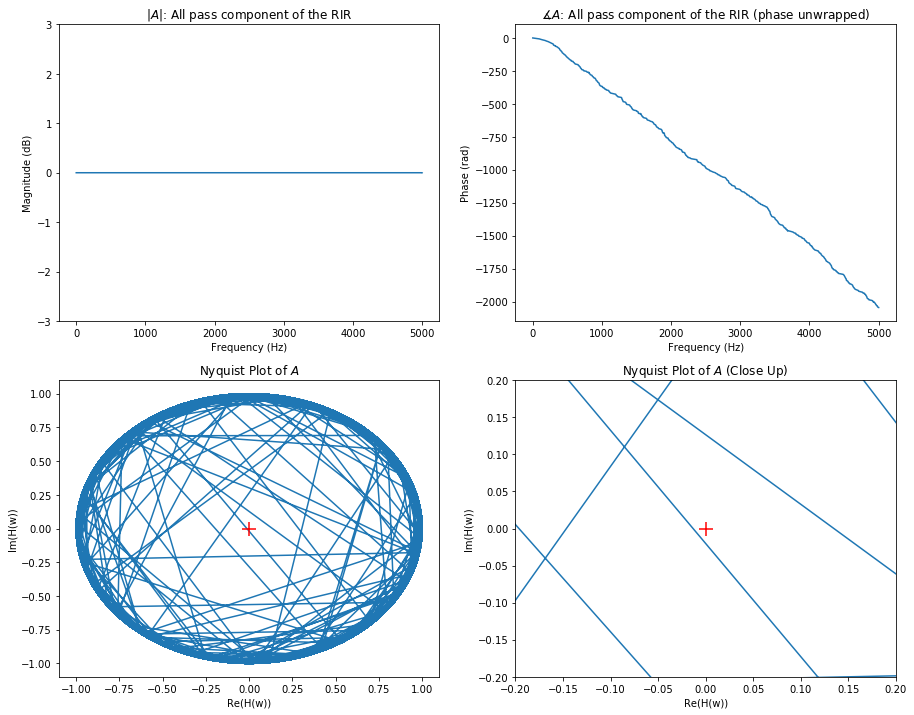

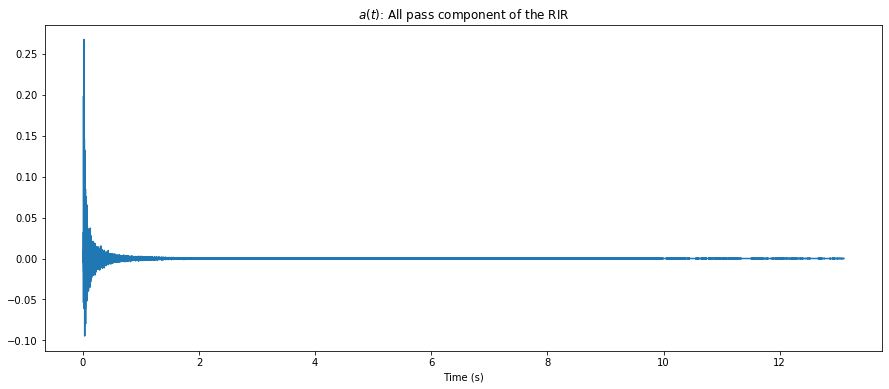

In [297]:
A=H*G
a = np.real(np.fft.ifft(A))
#unwrap
A_phase=np.unwrap(np.angle(A))

plt.figure(figsize=(15,12))
plt.subplot(2,2,1)
plt.title("$|A|$: All pass component of the RIR")
plt.plot(freqs[0:N_fft//2], librosa.amplitude_to_db(np.abs(A[0:N_fft//2])))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.ylim([-3,3])

plt.subplot(2,2,2)
plt.title('$\measuredangle A}$: All pass component of the RIR (phase unwrapped)')
plt.plot(freqs[0:N_fft//2],A_phase[0:N_fft//2]);
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (rad)')

plt.subplot(2,2,3)
plt.title('Nyquist Plot of $A$')
plt.plot(np.real(A[0:N_fft//2]), np.imag(A[0:N_fft//2]), zorder=-1) #shifted in 0... ok?! -np.real(T[0]) -np.imag(T[0])
plt.scatter(0,0, c='r', s=180, marker='+') #-1/np.real(T[0])
plt.ylabel('Im(H(w))')
plt.xlabel('Re(H(w))')

plt.subplot(2,2,4)
plt.title('Nyquist Plot of $A$ (Close Up)')
plt.plot(np.real(A[0:N_fft//2]), np.imag(A[0:N_fft//2]), zorder=-1) #shifted in 0... ok?! -np.real(T[0]) -np.imag(T[0])
plt.scatter(0,0, c='r', s=180, marker='+') #-1/np.real(T[0])
plt.ylabel('Im(H(w))')
plt.xlabel('Re(H(w))')
plt.xlim([-0.2,0.2])
plt.ylim([-0.2,0.2])

plt.figure(figsize=(15,6))

plt.title('$a(t)$: All pass component of the RIR')
time=time_axis(a,fs)
plt.plot(time, a)
plt.xlabel('Time (s)')
#plt.xlim([64536,65536])

plt.show()

Now we need to invert the all pass component: in order to do so we take its temporal inverse and we shift it making it causal

How much delay do we need to use? Until now we applied a shift of N_fft samples but what if it more or less?

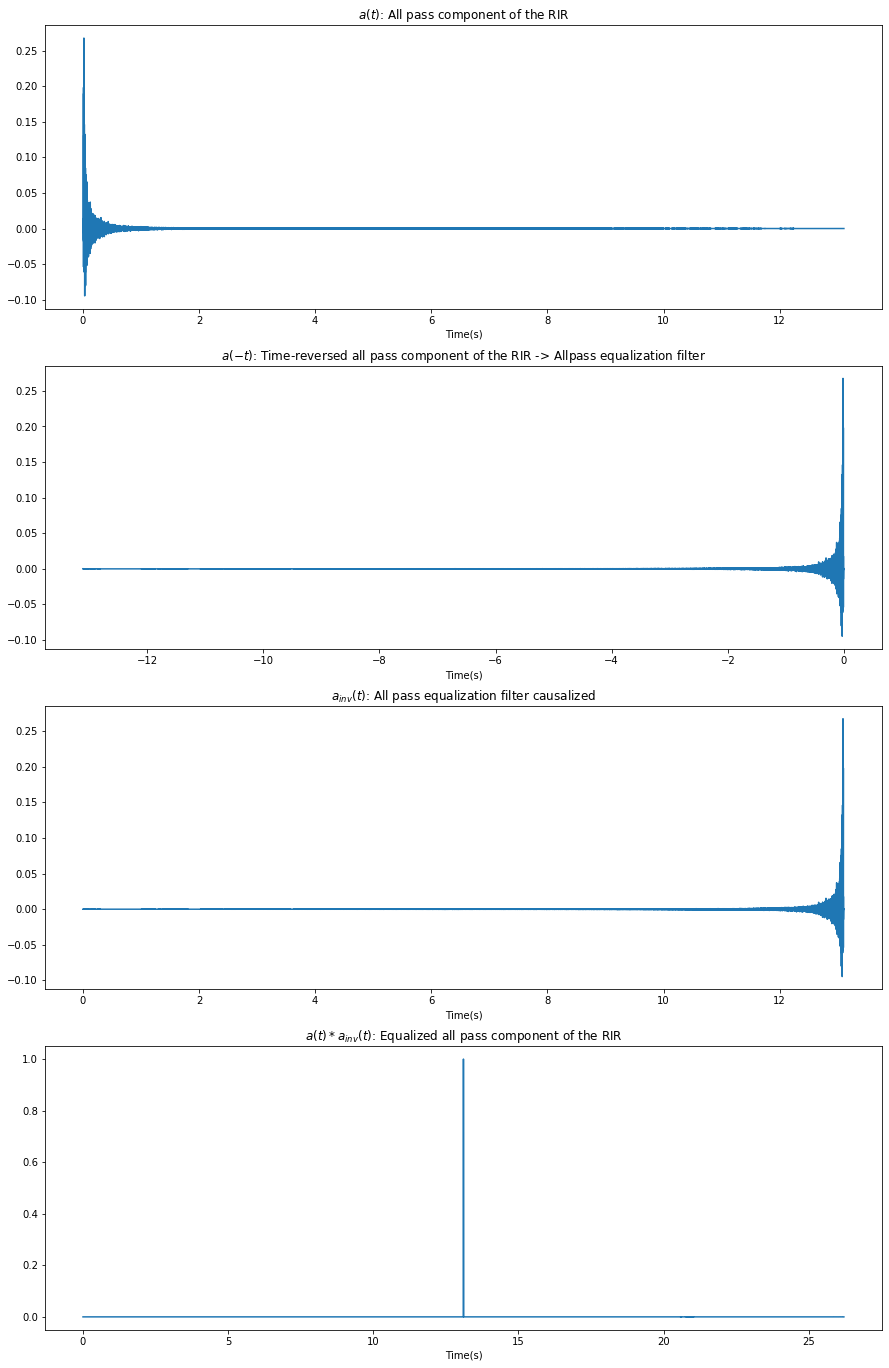

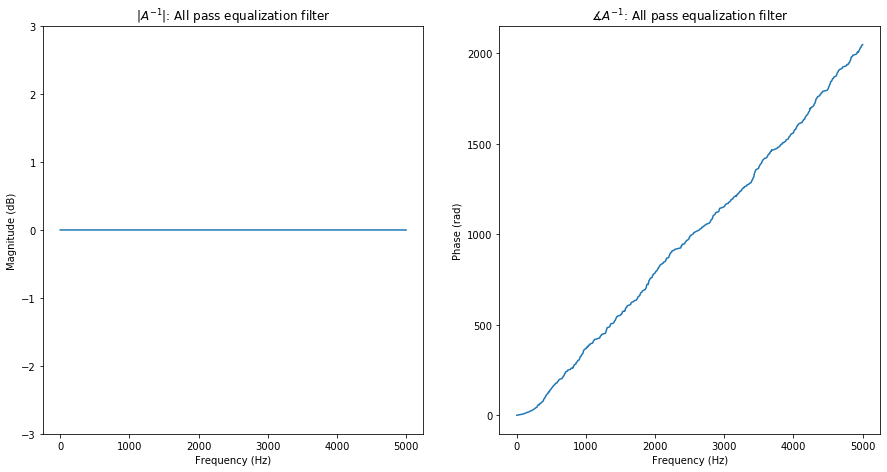

In [268]:
a = np.real(np.fft.ifft(A))

a_inv = a[::-1]

eq_a = np.convolve(a, a_inv)

# EQ = A*np.conj(A)
# eq = np.fft.ifft(EQ)

plt.figure(figsize=(15,24))
plt.subplot(4,1,1)
time=time_axis(a,fs)
plt.title('$a(t)$: All pass component of the RIR')
plt.plot(time, a)
plt.xlabel('Time(s)')
#plt.xlim([-0.001,0.1])

plt.subplot(4,1,2)
time=time_axis(a_inv,fs)
plt.title('$a(-t)$: Time-reversed all pass component of the RIR -> Allpass equalization filter')
plt.plot(-time[::-1], a_inv)
plt.xlabel('Time(s)')
#plt.plot(time, a)

plt.subplot(4,1,3)
time=time_axis(a_inv,fs)
plt.title('$a_{inv}(t)$: All pass equalization filter causalized')
plt.plot(time, a_inv)
plt.xlabel('Time(s)')

plt.subplot(4,1,4)
time=time_axis(eq_a,fs)
plt.title('$a(t)*a_{inv}(t)$: Equalized all pass component of the RIR')
plt.plot(time, eq_a)
plt.xlabel('Time(s)')

A_inv = np.fft.fft(a_inv, N_fft)
A_inv_phase=np.unwrap(np.angle(A_inv))

plt.figure(figsize=(15,7.5))
plt.subplot(1,2,1)
plt.title("$|A^{-1}|$: All pass equalization filter")
plt.plot(freqs[0:N_fft//2], librosa.amplitude_to_db(np.abs(A_inv[0:N_fft//2])))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.ylim([-3,3])

plt.subplot(1,2,2)
plt.title("$\measuredangle A^{-1}$: All pass equalization filter")
plt.plot(freqs[0:N_fft//2], A_inv_phase[0:N_fft//2])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (rad)')

plt.show()

Compute the group delay of the allpass component: \\[ \tau_{ga}(k) = -Im\left[\frac{A'(k)}{A(k)}\right] \\]
where \\( A'(k) = -j DFT[na(n)] \\)
and \\( a(n)=DFT^{-1}[A(k)] \\)

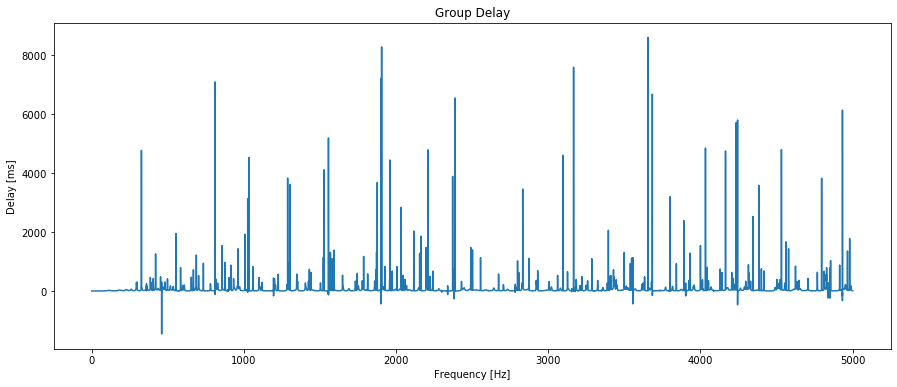

In [270]:
#group delay

index = np.arange(len(a))

na = a*index
freqs=np.arange(0,N_fft)*(fs/N_fft)

A_prime = -1j*np.fft.fft(na, N_fft)

tau_ga = -np.imag(A_prime/A)

tau_ga = (tau_ga)*1000/fs

plt.figure(figsize=(15, 6))
plt.plot(freqs[0:N_fft//2],tau_ga[0:N_fft//2])
plt.title('Group Delay')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Delay [ms]')

plt.show();

### Equalized Room Response
The frequency response of the original RIR equalized by the filters is the following:

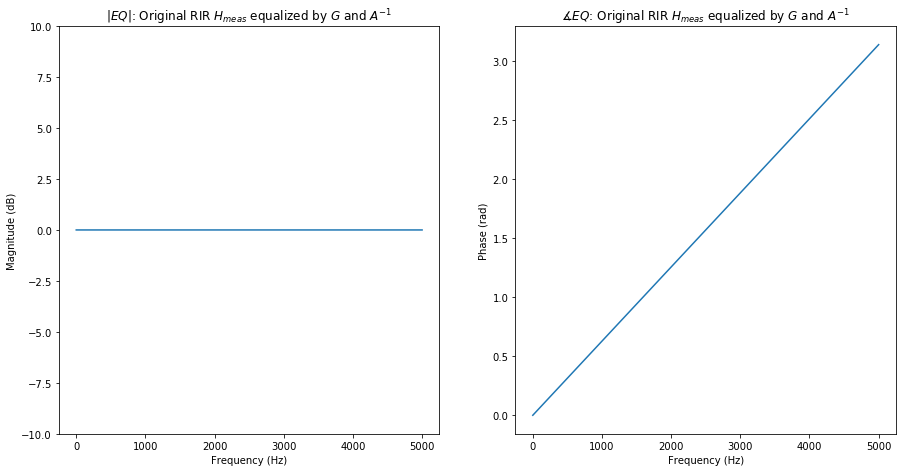

In [269]:
H_MEAS = np.fft.fft(h_meas, N_fft) # reference

EQ = H_MEAS*(G*A_inv)

plt.figure(figsize=(15, 7.5))

plt.subplot(1, 2, 1)
plt.title('$|EQ|$: Original RIR $H_{meas}$ equalized by $G$ and $A^{-1}$')
plt.plot(freqs[:N_fft//2], librosa.amplitude_to_db(np.abs(EQ)[:N_fft//2]))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.ylim([-10,10])

plt.subplot(1, 2, 2)
plt.title('$\\measuredangle EQ$: Original RIR $H_{meas}$ equalized by $G$ and $A^{-1}$')
plt.plot(freqs[:N_fft//2], np.angle(EQ)[:N_fft//2]);
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (rad)')

plt.show()

### Results
Apply to signal and see the result:

In [276]:
# zero pad signals before filtering (or OLA)

SIGNAL_REV = np.fft.fft(signal_rev, N_fft)
SIGNAL_RECOVERED_MP = G * SIGNAL_REV

signal_recovered_mp=np.real(np.fft.ifft(SIGNAL_RECOVERED_MP))

signal_recovered = np.real(np.fft.ifft(SIGNAL_RECOVERED_MP*A_inv))

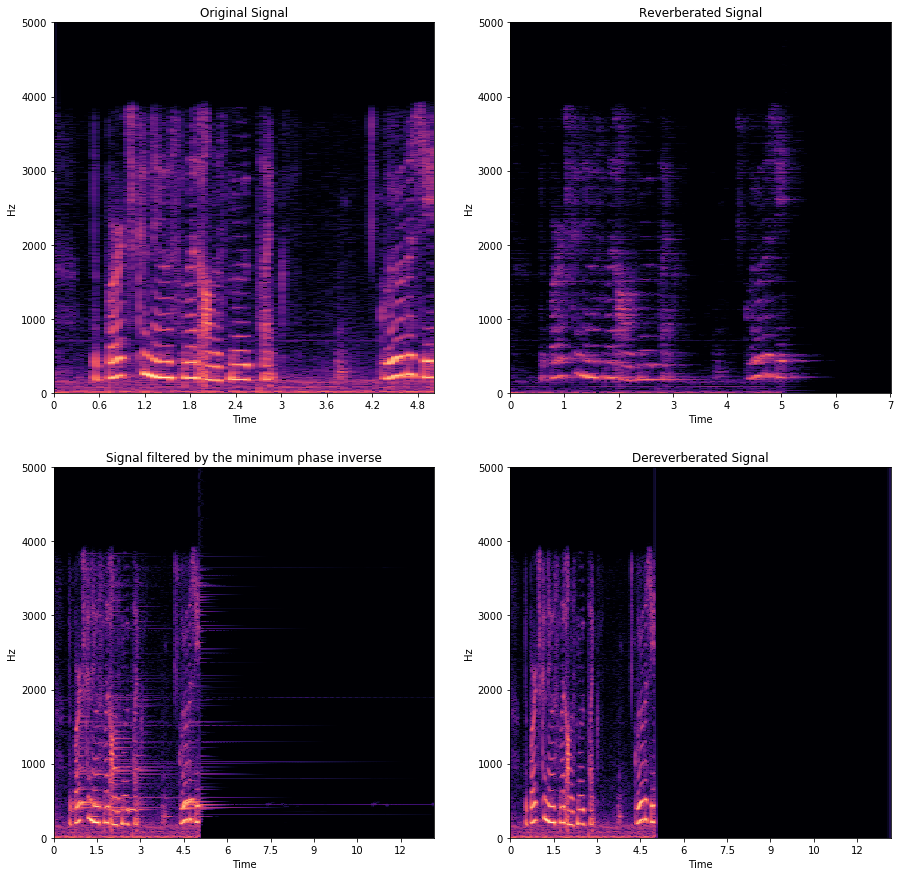

In [275]:
plt.figure(figsize=(15, 15))
plt.subplot(2,2,1)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max), sr=fs, x_axis='time', y_axis='linear')
plt.title('Original Signal')

plt.subplot(2,2,2)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(signal_rev)), ref=np.max), sr=fs, x_axis='time', y_axis='linear')
plt.title('Reverberated Signal')

plt.subplot(2,2,3)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(signal_recovered_mp)), ref=np.max), sr=fs, x_axis='time', y_axis='linear')
plt.title('Signal filtered by the minimum phase inverse')

plt.subplot(2,2,4)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(signal_recovered)), ref=np.max), sr=fs, x_axis='time', y_axis='linear')
plt.title('Dereverberated Signal')

plt.show()

#### Audio files comparison

In [272]:
# dry
print("Dry Signal")
ipd.display(ipd.Audio(audio, rate=fs, normalize=True))

# wet
print("Wet Signal")
ipd.display(ipd.Audio(signal_rev, rate=fs, normalize=True))

# filtered: reverberated
print("Minimum phase inverse filter applied")
ipd.display(ipd.Audio(signal_recovered_mp, rate=fs, normalize=True))

# filtered: reverberated
print("Inverse filter applied")
ipd.display(ipd.Audio(signal_recovered, rate=fs, normalize=True))

Dry Signal


Wet Signal


Minimum phase inverse filter applied


Inverse filter applied


### Minimum-Phase/Allpass Decomposition: Novel Approach

1. Calculate $H(n)$, $\hat{H}(n)$, $\hat{h}_{e}(k)$, as we already did before.

2. Calculate the corresponding complex cepstrum of the minimum phase sequence: $$\hat{h}_{mp}^{1/L}(k) = \begin{cases} \hat{h}_e(k)/L, & k=0,N/2 \\ 2\hat{h}_e(k)/L, & 1\leq k < N/2\\ 0, & N/2 < k \leq N-1 \end{cases} $$

3. Compute the DFT of $\hat{h}_{mp}^{1/L}(k)$, $\hat{H}_{mp}^{1/L}(k)$

4. Infer the minimum phase part $H_{mp}^{1/L}(k)$, as the exponential function of $\hat{H}_{mp}^{1/L}(k)$

5. Calculate the frequency response $H^{(l+1)}(n)$, as: $$H^{(l+1)}(n)= \frac{H^{(l)}(n)}{H^{1/L}_{mp}(n)}$$

where $H^{(l+1)}(n)$ denotes the partly equalized room transfer function resulting from the $(l+1)^{th}$ stage of computation $(l = 0,1,. . . , L-1)$,
and $H^{(0)}(n) = H(n)$

### Graph comparison:

### Phase Equalization